In [125]:
%load_ext autoreload
%autoreload
%matplotlib inline

import os
import sys
import glob
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import display
from pathlib import Path
from smart_open import open
from tqdm.autonotebook import tqdm
tqdm.pandas()

import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns
import spacy
from tokenizer import MergedTokenizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
nlp = spacy.load('en_core_web_lg')

In [12]:
data = []
for cat in tqdm(os.listdir('bbc')):
    for fname in glob.glob('bbc/' + cat + '/*.txt'):
        file = Path(fname)
        iid = cat + '-' + file.name.split('.')[0]
        try:
            txt = file.read_text(encoding='utf', errors='ignore')
        except:
            print(iid)
        data.append([iid, txt, cat])
        
df = pd.DataFrame(data, columns=['ArticleId', 'Text', 'Category']); df;

In [17]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id'); category_id_df

,Category,category_id
0,business,0
510,entertainment,1
896,politics,2
1313,sport,3
1824,tech,4


In [18]:
category_to_id = dict(category_id_df.values); category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [19]:
id_to_category = dict(category_id_df[['category_id', 'Category']].values); id_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [20]:
df.sample(5, random_state=0)

,ArticleId,Text,Category,category_id
384,business-385,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,0
1983,tech-160,Halo 2 sells five million copies\n\nMicrosoft ...,tech,4
985,politics-090,MSPs hear renewed climate warning\n\nClimate c...,politics,2
1386,sport-074,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,3
1294,politics-399,Tories reject rethink on axed MP\n\nSacked MP ...,politics,2


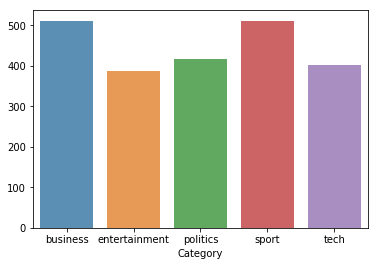

In [36]:
_data = df.groupby('Category').category_id.count()
sns.barplot(_data.index, _data.values, alpha=0.8)

In [37]:
merged_tokenizer = MergedTokenizer(nlp)
spacy_tokenizer = lambda rawtext: merged_tokenizer.lemmatized(rawtext)

In [55]:
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer, sublinear_tf=True, min_df=5)#, encoding='latin-1')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.category_id; features.shape

(2225, 7413)

In [56]:
N = 5

for Category, category_id in tqdm(sorted(category_to_id.items())):
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    print('# {}'.format(Category))
    print('  .Most correlated features:\n    .{}'.format('\n    .'.join(feature_names[-N:])))

# business
  .Most correlated features:
    .profit
    .economy
    .oil
    .bank
    .growth
# entertainment
  .Most correlated features:
    .oscar
    .actor
    .star
    .award
    .film
# politics
  .Most correlated features:
    .blair
    .party
    .election
    .tory
    .labour
# sport
  .Most correlated features:
    .injury
    .champion
    .coach
    .match
    .cup
# tech
  .Most correlated features:
    .mobile
    .software
    .technology
    .computer
    .user



In [40]:
tfidf.get_feature_names()

['$1.1bn',
 '$1.2bn',
 '$1.5bn',
 '$1.6bn',
 '$1.8bn',
 '$100m',
 '$1bn',
 '$1m',
 '$20bn',
 '$24m',
 '$250',
 '$250,000',
 '$27.5bn',
 '$300m',
 '$40m',
 '$50',
 '$50,000',
 '$500m',
 '$50m',
 '$550,000',
 '$5m',
 '$600m',
 '$800m',
 '$9.3bn',
 '$9.4bn',
 '0',
 '0.1%',
 '0.2%',
 '0.3%',
 '0.4%',
 '0.5%',
 '0.6%',
 '0.7%',
 '0.8%',
 '1',
 '1%',
 '1,000',
 '1.1%',
 '1.2%',
 '1.3%',
 '1.5%',
 '1.6%',
 '1.7%',
 '1.8%',
 '10',
 '10%',
 '10,000',
 '10,000m',
 '10-day',
 '10-year',
 '100',
 '100%',
 '100,000',
 '100_million',
 '100m',
 '101',
 '10_days',
 '10_million',
 '10_minutes',
 '10_years',
 '10bn',
 '10th',
 '11',
 '11%',
 '110',
 '11_september',
 '11bn',
 '11th',
 '12',
 '12%',
 '120',
 '1200_gmt',
 '12_months',
 '12_years',
 '12th',
 '13',
 '13%',
 '13th',
 '14',
 '14%',
 '14,000',
 '14-year',
 '15',
 '15%',
 '15-year',
 '150',
 '150,000',
 '1500m',
 '15_january',
 '15_years',
 '15th',
 '16',
 '16%',
 '16-year',
 '16bn',
 '17',
 '17%',
 '17-year',
 '17_april',
 '17_december',
 '17_j

In [57]:
SAMPLE_SIZE = int(len(features)*0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]); projected_features.shape

(667, 2)

In [58]:
category_id_test = 0
projected_features[labels[indices]==category_id_test]

array([[ 22.770971 , -31.251482 ],
       [ 45.08549  , -10.089775 ],
       [ 27.876585 , -15.712259 ],
       [ 14.589272 , -31.784988 ],
       [ 26.272919 ,  13.525208 ],
       [ 33.716736 ,  -1.2496587],
       [ 14.900104 , -23.911482 ],
       [ -7.81853  ,   1.8150959],
       [ 39.00803  , -17.169657 ],
       [ 22.343666 , -10.926634 ],
       [ 38.13762  ,  -8.854015 ],
       [ 24.710087 , -20.07556  ],
       [ 25.407639 , -22.707352 ],
       [ 20.41031  , -30.070562 ],
       [ 30.66292  , -21.56624  ],
       [  5.7034283, -14.167711 ],
       [ 34.697643 , -22.897629 ],
       [ 11.128526 , -19.809162 ],
       [  9.077125 , -16.096754 ],
       [  5.509421 , -10.029763 ],
       [ 26.965033 ,  -8.419853 ],
       [ 36.547817 ,  -9.442074 ],
       [ 37.453316 ,  -8.280098 ],
       [ 38.184597 ,  -5.7924323],
       [ 15.32018  , -30.688173 ],
       [ 38.916813 ,  -6.059986 ],
       [ 36.305447 , -25.942621 ],
       [  7.4272165, -17.26558  ],
       [ 32.40735  ,

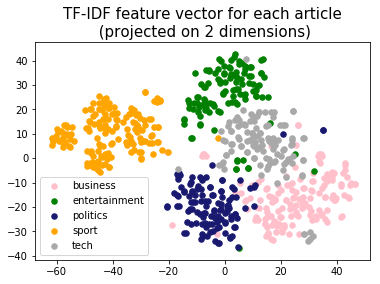

In [59]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

for category, category_id in sorted(category_to_id.items()):
    points = projected_features[labels[indices]==category_id]
    plt.scatter(points[:,0], points[:,1], s=30, c=colors[category_id], label=category)
    
plt.title('TF-IDF feature vector for each article\n (projected on 2 dimensions)', fontdict=dict(fontsize=15))
plt.legend();

In [130]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), 
    MultinomialNB(), 
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto'), 
    SGDClassifier(random_state=0, max_iter=100, tol=1e-3), 
    SVC(kernel='rbf', C=1, gamma='auto')
]

In [131]:
CV = 5
shufflesplit = ShuffleSplit(n_splits=CV, test_size=0.2, random_state=0)
entries = []

for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=shufflesplit)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [132]:
cv_df = pd.DataFrame(entries, index=range(CV*len(models)), columns=['model_name', 'fold_idx', 'accuracy']); cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.892135
1,RandomForestClassifier,1,0.865169
2,RandomForestClassifier,2,0.853933
3,RandomForestClassifier,3,0.842697
4,RandomForestClassifier,4,0.858427
5,MultinomialNB,0,0.964045
6,MultinomialNB,1,0.968539
7,MultinomialNB,2,0.964045
8,MultinomialNB,3,0.961798
9,MultinomialNB,4,0.977528


In [117]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.978876
MultinomialNB             0.967191
RandomForestClassifier    0.862472
SGDClassifier             0.979775
Name: accuracy, dtype: float64

In [133]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.978876
MultinomialNB             0.967191
RandomForestClassifier    0.862472
SGDClassifier             0.979775
SVC                       0.213483
Name: accuracy, dtype: float64

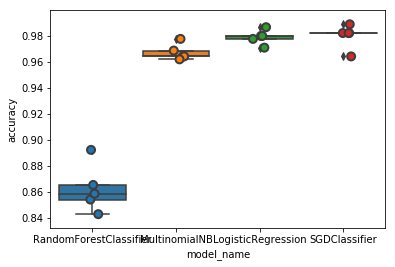

In [118]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)

In [119]:
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [120]:
conf_mat = confusion_matrix(y_test, y_pred); conf_mat

array([[170,   0,   2,   0,   1],
       [  0, 121,   2,   0,   0],
       [  2,   0, 138,   0,   0],
       [  1,   0,   0, 172,   0],
       [  3,   0,   0,   0, 123]], dtype=int64)

Text(0.5, 15.0, 'Predicted')

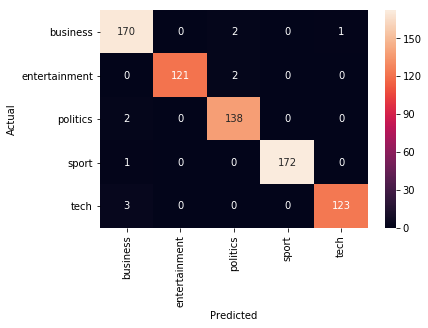

In [121]:
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [122]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print('{} predicted as {}: {} examples'.format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test==actual) & (y_pred==predicted)]]['Text'])

politics predicted as business: 2 examples


971    Report attacks defence spending\n\nThe Ministr...
979    Job cuts 'false economy'  - TUC\n\nPlans to sh...
Name: Text, dtype: object

tech predicted as business: 3 examples


2065    PC ownership to 'double by 2010'\n\nThe number...
1942    Argonaut founder rebuilds empire\n\nJez San, t...
1937    Games maker fights for survival\n\nOne of Brit...
Name: Text, dtype: object

business predicted as politics: 2 examples


503    Aids and climate top Davos agenda\n\nClimate c...
486    World leaders gather to face uncertainty\n\nMo...
Name: Text, dtype: object

entertainment predicted as politics: 2 examples


722    TV show unites Angolan families\n\nAngolan fam...
711    BBC 'should allow more scrutiny'\n\nMPs have u...
Name: Text, dtype: object

In [123]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [124]:
N = 3

for Category, category_id in tqdm(sorted(category_to_id.items())):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' '))==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print('# {}'.format(Category))
    print('  .Most correlated unigrams:\n    .{}'.format('\n    .'.join(unigrams[-N:])))
    print('  .Most correlated bigrams:\n    .{}'.format('\n    .'.join(bigrams[-N:])))

# business
  .Most correlated unigrams:
    .bank
    .firm
    .company
  .Most correlated bigrams:
    .
# entertainment
  .Most correlated unigrams:
    .music
    .star
    .film
  .Most correlated bigrams:
    .
# politics
  .Most correlated unigrams:
    .minister
    .labour
    .party
  .Most correlated bigrams:
    .
# sport
  .Most correlated unigrams:
    .match
    .club
    .win
  .Most correlated bigrams:
    .
# tech
  .Most correlated unigrams:
    .technology
    .user
    .computer
  .Most correlated bigrams:
    .


In [369]:
fnames_test = glob.glob('newsdata/downloaded/*.json')[-10:]

test_data = []
for fname in fnames_test:
    with open(fname, encoding='UTF-8-sig') as f:
        content = json.load(f)
        test_data.append(content['text'])

In [370]:
fnames_test

['newsdata/downloaded\\fff47dea8c8524dafd819ff0f4d7fb3bf2c3eb2e.json',
 'newsdata/downloaded\\fff621185296f1b62d4b04dde73c639c3e9fa0c3.json',
 'newsdata/downloaded\\fff73d2c153889201898f4953e31a0df81ccfd49.json',
 'newsdata/downloaded\\fffb3a399e07b0ca9f168caa2d298d6c7970ebd7.json',
 'newsdata/downloaded\\fffba400853301314ebcbe0a04b4e2200cbc9330.json',
 'newsdata/downloaded\\fffc4188682480a47f2eff3b2b48235cecaf1ce4.json',
 'newsdata/downloaded\\fffcfcad4d05790822d9998aff8e441231c6f295.json',
 'newsdata/downloaded\\fffcfe6039c7646939c5337a4f50b18fb6efbeb7.json',
 'newsdata/downloaded\\fffeea1e862eba451cfad35162fed9232ef7c8ad.json',
 'newsdata/downloaded\\ffff48de38a87141429864e0412283d68d96cc98.json']

In [371]:
test_features = tfidf.transform(test_data)

In [372]:
Y_pred = model.predict(test_features); Y_pred

array([0, 0, 2, 0, 3, 0, 4, 0, 0, 0], dtype=int64)

In [373]:
[id_to_category[cat_id] for cat_id in Y_pred]

['business',
 'business',
 'politics',
 'business',
 'sport',
 'business',
 'tech',
 'business',
 'business',
 'business']

In [377]:
with open('newsdata/downloaded/ffff48de38a87141429864e0412283d68d96cc98.json') as f:
    content = json.load(f)
    print(content['text'])

There is no let-up in the downward spiral of the share values of Uber Technologies (NYSE: ) and LYFT (NASDAQ: ). Both ride-hailing companies have lost almost a quarter of their market capitalization during the past month on concerns that there is no for these companies to achieve profitability.

The shares have plummeted since their IPOs: Closing yesterday at $32.24, Uber is down more than 22% from its maiden trade in May, while Lyft has plunged more than 43% from its March start, to end yesterday's trading at $44.38.

Uber, Lyft price charts

Since they hit the public markets with their IPOs this year, their rides have become ever bumpier as their losses widened and competition grew even stiffer. In the second-quarter reporting season that ended recently, both companies spooked investors with higher-than-expected losses. Uber a net loss of $5.24 billion, while Lyft a $644.2-million loss — more than three times higher than its loss in the year-earlier period.

This dire financial situa

In [449]:
TRAINING_DATA = []
newscat = {'business':False, 'entertainment':False, 'politics':False, 'sport':False, 'tech':False}

for row in tqdm(df.iloc[:][['Text','Category']].itertuples()):
    data = [spacy_tokenizer(row.Text), {**newscat,  row.Category:True}]
    TRAINING_DATA.append(data)

In [451]:
TRAINING_DATA;

In [455]:
import spacy
import random
import json

# TRAINING_DATA = [
#     ["My little kitty is so special", {"animal": True, 'device':False}],
#     ["Dude, Totally, Yeah, Video Games", {"animal": False, 'device':True}],
#     ["Should I pay $1,000 for the iPhone X?", {"animal": False, 'device':True}],
#     ["The iPhone 8 reviews are here", {"animal": False, 'device':True}],
#     ["Noa is a great cat name.", {"animal": True, 'device':False}],
#     ["We got a new kitten!", {"animal": True, 'device':False}]
# ]

# nlp2 = spacy.blank("en")
if not nlp.has_pipe('textcat'):
    category = nlp.create_pipe("textcat")
    # category.add_label("animal")
    # category.add_label("device")

    category.add_label("business")
    category.add_label("entertainment")
    category.add_label("politics")
    category.add_label("sport")
    category.add_label("tech")
    nlp.add_pipe(category)

# Start the training
nlp.begin_training()

# Loop for 10 iterations
for itn in tqdm(range(100)):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    losses = {}

    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size=1):
        #set_trace()
        texts = [text for text, entities in batch]
        #texts = [nlp2(text) for text, entities in batch]
        annotations = [{"cats": entities} for text, entities in batch]
        nlp.update(texts, annotations, losses=losses)
        
    if itn % 20 == 0:
        print(losses)

AttributeError: 'str' object has no attribute 'text'

In [390]:
list(spacy.util.minibatch(TRAINING_DATA, size=1))

[[['The iPhone 8 reviews are here', {'animal': False, 'device': True}]],
 [['Dude, Totally, Yeah, Video Games', {'animal': False, 'device': True}]],
 [['We got a new kitten!', {'animal': True, 'device': False}]],
 [['Should I pay $1,000 for the iPhone X?',
   {'animal': False, 'device': True}]],
 [['My little kitty is so special', {'animal': True, 'device': False}]],
 [['Noa is a great cat name.', {'animal': True, 'device': False}]]]

In [439]:
nlp2('so cute my cat').cats

{'animal': 0.9728940725326538, 'device': 0.252625435590744}